Initial balance for user 10 (28-Feb-2025): €-26,645
✔ Simulation output saved → C:\Users\loics\OneDrive\Documents\1. BAM\BLOCK 5\Assignment coding\full_simulation_output.csv


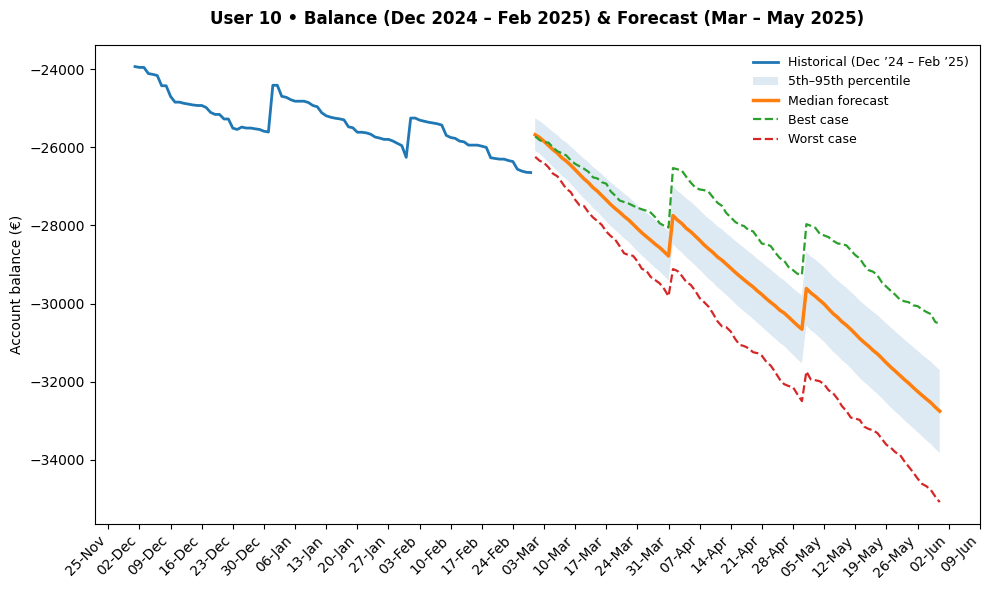


---------------- Value at Risk (92-day horizon) ----------------
95 % VaR  : €7,178
99 % VaR  : €7,657
95 % CVaR : €7,457
99 % CVaR : €7,844


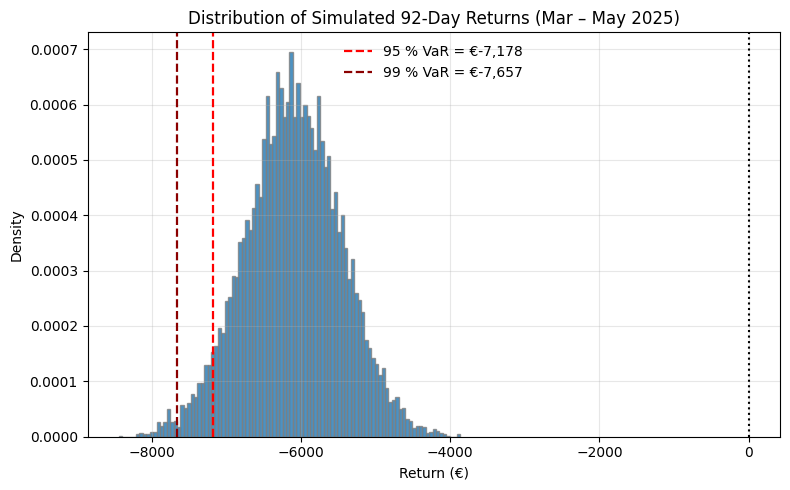


--- Value at Risk over 92-day horizon ---
95 % VaR: €7,178   99 % VaR: €7,657

--- Rule-based Insights & Recommendations ---
We modelled 10,000 paths for the next 92 days. On average, your balance ends around €-32,800. In 95 % of cases it lands between €-31,700 and €-33,800. The 95 % worst-case loss over the period is about €7,200.

⚠️ **Already overdrawn; risk of deeper overdraft ahead.**
Median projection bottoms at −€32,800. You’re expected to spend about €2,000 more than you earn **each month**.

• Top-up **€26,600** now to reach €0.
• Add another **€7,200** to stay safe in 95 % of cases.
• Cut monthly spending **9%** to slow the deficit.


In [ ]:
# ------------------------------------------------------------
# Monte-Carlo Simulation, VaR, Dashboard Plot & Rules-Based Insights
# ------------------------------------------------------------
import os, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

# ------------------------------------------------------------
# CONFIGURATION
# ------------------------------------------------------------
BASE_DIR = Path(r"C:/Users/loics/OneDrive/Documents/1. BAM/BLOCK 5/Assignment coding")
HIST_CSV = BASE_DIR / "synthetic_transactions_daily_enriched.csv"
PRED_CSV = BASE_DIR / "final_income_expense_predictions.csv"
SIM_CSV  = BASE_DIR / "full_simulation_output.csv"
NUM_SIMULATIONS = 10_000
USER_ID = 10

# ------------------------------------------------------------
# 1. Historical running balance
# ------------------------------------------------------------
hist = pd.read_csv(HIST_CSV, usecols=["user_id", "date", "net_cash_flow"])
hist["date"] = pd.to_datetime(hist["date"])
hist = hist[hist["user_id"] == USER_ID].sort_values("date")
hist["balance"] = hist["net_cash_flow"].cumsum()

hist_until_feb  = hist[hist["date"] <= "2025-02-28"]
initial_balance = hist_until_feb.iloc[-1]["balance"]
print(f"Initial balance for user {USER_ID} (28-Feb-2025): €{initial_balance:,.0f}")

hist_plot = hist[(hist["date"] >= "2024-12-01") & (hist["date"] <= "2025-02-28")]

# ------------------------------------------------------------
# 2. Load predicted percentiles (Mar–May 2025)
# ------------------------------------------------------------
pred = pd.read_csv(PRED_CSV, parse_dates=["date"])
pred = pred[(pred["date"] >= "2025-03-01") & (pred["date"] <= "2025-05-31")].reset_index(drop=True)

num_days       = len(pred)
forecast_dates = pred["date"].to_numpy()

# ------------------------------------------------------------
# 3. Monte-Carlo simulation
# ------------------------------------------------------------
sim_balances = np.zeros((NUM_SIMULATIONS, num_days), dtype=float)

for sim in range(NUM_SIMULATIONS):
    bal = initial_balance
    for day_idx, row in pred.iterrows():
        inc = np.random.uniform(row["income_p10"], row["income_p90"])
        exp = np.random.uniform(min(row["expense_p10"], row["expense_p90"]),
                                max(row["expense_p10"], row["expense_p90"]))
        bal += inc + exp
        sim_balances[sim, day_idx] = bal

# ------------------------------------------------------------
# 4. Save simulation paths
# ------------------------------------------------------------
col_names = pred["date"].dt.strftime("%Y-%m-%d").tolist()
pd.DataFrame(sim_balances, columns=col_names)\
  .assign(Simulation=lambda df: np.arange(1, NUM_SIMULATIONS+1))\
  .set_index("Simulation")\
  .to_csv(SIM_CSV)
print(f"✔ Simulation output saved → {SIM_CSV}")

# ------------------------------------------------------------
# 5. Key paths for plot
# ------------------------------------------------------------
median_path = np.percentile(sim_balances, 50, axis=0)
p5_path     = np.percentile(sim_balances, 5,  axis=0)
p95_path    = np.percentile(sim_balances, 95, axis=0)

final_balances = sim_balances[:, -1]
best_path  = sim_balances[final_balances.argmax()]
worst_path = sim_balances[final_balances.argmin()]

# ------------------------------------------------------------
# 6. Plot balance fan chart
# ------------------------------------------------------------
hist_series   = pd.Series(hist_plot["balance"].values, index=hist_plot["date"])
median_series = pd.Series(median_path, index=forecast_dates)
best_series   = pd.Series(best_path,   index=forecast_dates)
worst_series  = pd.Series(worst_path,  index=forecast_dates)
p5_series     = pd.Series(p5_path,     index=forecast_dates)
p95_series    = pd.Series(p95_path,    index=forecast_dates)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(hist_series.index, hist_series.values, linewidth=2, label="Historical (Dec ’24 – Feb ’25)")
ax.fill_between(forecast_dates, p5_series, p95_series, alpha=0.15, label="5th–95th percentile")
ax.plot(median_series, linewidth=2.5, label="Median forecast")
ax.plot(best_series, linestyle="--", linewidth=1.6, label="Best case")
ax.plot(worst_series, linestyle="--", linewidth=1.6, label="Worst case")
ax.axhline(0, linestyle=":", color="gray")
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

y_min = min(hist_series.min(), p5_series.min(), worst_series.min())
y_max = max(hist_series.max(), p95_series.max(), best_series.max())
margin = (y_max - y_min) * 0.05
ax.set_ylim(y_min - margin, y_max + margin)

ax.set_title(f"User {USER_ID} • Balance (Dec 2024 – Feb 2025) & Forecast (Mar – May 2025)",
             weight="bold", pad=15)
ax.set_ylabel("Account balance (€)")
ax.legend(frameon=False, fontsize=9)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 7. VaR & CVaR (92-day horizon)
# ------------------------------------------------------------
returns_92d = final_balances - initial_balance
VaR_95  = np.percentile(returns_92d, 5)
VaR_99  = np.percentile(returns_92d, 1)
CVaR_95 = returns_92d[returns_92d <= VaR_95].mean()
CVaR_99 = returns_92d[returns_92d <= VaR_99].mean()

print("\n---------------- Value at Risk (92-day horizon) ----------------")
print(f"95 % VaR  : €{abs(VaR_95):,.0f}")
print(f"99 % VaR  : €{abs(VaR_99):,.0f}")
print(f"95 % CVaR : €{abs(CVaR_95):,.0f}")
print(f"99 % CVaR : €{abs(CVaR_99):,.0f}")

# ------------------------------------------------------------
# 8. Histogram of 92-day returns
# ------------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.hist(returns_92d, bins=100, density=True, edgecolor="gray", alpha=0.8)
plt.axvline(VaR_95, color="red",     linestyle="--", linewidth=1.6, label=f"95 % VaR = €{VaR_95:,.0f}")
plt.axvline(VaR_99, color="darkred", linestyle="--", linewidth=1.6, label=f"99 % VaR = €{VaR_99:,.0f}")
plt.axvline(0, color="black", linestyle=":")
plt.title("Distribution of Simulated 92-Day Returns (Mar – May 2025)")
plt.xlabel("Return (€)")
plt.ylabel("Density")
plt.legend(frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 9. Rules-based insights & recommendations
# ------------------------------------------------------------
# ---------------- 9.1. · VaR / CVaR ----------------
returns_92d = final_balances - initial_balance
VaR_95  = np.percentile(returns_92d, 5)
VaR_99  = np.percentile(returns_92d, 1)
CVaR_95 = returns_92d[returns_92d <= VaR_95].mean()
CVaR_99 = returns_92d[returns_92d <= VaR_99].mean()

print("\n--- Value at Risk over 92-day horizon ---")
print(f"95 % VaR: €{abs(np.round(VaR_95)):,.0f}   99 % VaR: €{abs(np.round(VaR_99)):,.0f}")

# ---------------- 9.2. · Rule-based insights ----------------
def r100(x): return int(np.round(x, -2))

prob_od  = (sim_balances < 0).any(axis=1).mean()          # overdraft probability
mean_end = final_balances.mean()
median_end = np.percentile(final_balances, 50)
median_low = np.percentile(sim_balances.min(axis=1), 50)
buf_needed = max(0, -VaR_95)
monthly_gap = -(mean_end - initial_balance) / (num_days/30)  # € overspend per 30 days
best_95 = np.percentile(final_balances, 95)
worst_95 = np.percentile(final_balances, 5)

# --- 9.2.1 Intro sentences ---
intro = (
    f"We predicted your income and expenses the next {num_days} days, and modelled {NUM_SIMULATIONS:,} potential paths for the same period. "
    f"On average, your balance is predicted to end at around €{r100(median_end):,}. "
    f"In 95 % of cases it is predicted to land between €{r100(best_95):,} and €{r100(worst_95):,}. "
    f"With 95% confidence, the worst-case loss over the period is predicted to be about €{abs(r100(VaR_95)):,}."
)

# --- 9.2.2 Headline ---
if initial_balance < 0:
    headline = "⚠️ **Already overdrawn; risk of deeper overdraft ahead.**"
else:
    if prob_od < 0.20 and mean_end >= 0:
        headline = "**Your outlook is healthy; overdraft risk is low.**"
    elif prob_od < 0.60:
        headline = "**Caution: You could dip below zero in some scenarios.**"
    else:
        headline = "⚠️ **High overdraft risk: most paths fall below €0.**"

# --- 9.2.3 Supporting fact ---
if initial_balance < 0:
    support = f"Median projection bottoms at −€{abs(r100(median_low)):,}."
else:
    support = f"Median projection ends at €{r100(median_end):,}."

if abs(monthly_gap) > 500:       # > €500 per month gap
    if monthly_gap > 0:
        support += f" You are expected to spend about €{r100(monthly_gap):,} more than you earn **each month**."
    else:
        support += f" You are expected to earn about €{r100(-monthly_gap):,} more than you spend each month."

# --- 9.2.4 Recommendations ---
bullets = []

if initial_balance < 0:                                  # already negative
    top_up_zero = r100(-initial_balance)
    bullets.append(f"Top-up **€{top_up_zero:,}** now to reach €0.")
    if buf_needed > 0:
        bullets.append(f"Add another **€{r100(buf_needed):,}** to stay safe in 95 % of cases.")
else:                                                    # starting positive
    if buf_needed > 0:
        bullets.append(f"Save **€{r100(buf_needed):,}** to avoid overdraft in 95 % of cases.")

if monthly_gap > 500 and len(bullets) < 3:
    pct = int(min(30, max(5, monthly_gap / (abs(monthly_gap)+1) * 10)))
    bullets.append(f"Cut monthly spending **{pct}%** to slow the deficit.")

if prob_od > 0.60 and len(bullets) < 3:
    bullets.append("Enable low-balance alerts before hitting €0.")

if initial_balance > 0 and prob_od < 0.20 and len(bullets) < 3:
    bullets.append("Consider moving surplus to a savings or investment pocket.")

if len(bullets) < 3:
    bullets.append("Review subscriptions and cancel unused ones.")

bullets = bullets[:3]

# --- 9.2.5 Display ---
print("\n--- Rule-based Insights & Recommendations ---")
print(intro)
print()
print(headline)
print(support)
print()
for b in bullets:
    print("• " + b)



